# I - Import thư viện

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tqdm  
import seaborn as sns

# II - Đọc dữ liệu từ file CSV

In [4]:
data = pd.read_csv("./data/data-commerce.csv") 
print(data.shape)

(42448764, 9)


In [5]:
new_data = data.head(500_000)

new_data.to_csv("./data/data-commerce-after.csv", index=False)
print("Đã lưu 500 nghìn bản ghi vào file CSV mới.") 

print(new_data.shape) 
new_data.head()

Đã lưu 500 nghìn bản ghi vào file CSV mới.
(500000, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


# III - Tiền xử lý dữ liệu

#### Tiến hành loại bỏ các hàng có giá trị missing value : 

In [6]:
new_data_clean = new_data.dropna() 

print("Đã lưu dữ liệu sau khi xóa missing value vào file CSV mới.")

Đã lưu dữ liệu sau khi xóa missing value vào file CSV mới.


#### Tiến hành loại bỏ các cột không cần thiết :

In [7]:
new_data_clean = new_data_clean.drop(["category_id", "user_session"], axis=1)
new_data_clean["brand"] = new_data_clean["brand"].astype("category")

new_data_clean.to_csv("./data/data-commerce-cleaned-categories.csv", index=False)
print("Đã lưu dữ liệu sau khi loại bỏ các cột không cần thiết vào file CSV mới.")

Đã lưu dữ liệu sau khi loại bỏ các cột không cần thiết vào file CSV mới.


In [8]:
print(new_data_clean.shape)
new_data_clean.head()

(315171, 7)


,event_time,event_type,product_id,category_code,brand,price,user_id
1,2019-10-01 00:00:00 UTC,view,3900821,appliances.environment.water_heater,aqua,33.20,554748717
3,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,lenovo,251.74,550050854
4,2019-10-01 00:00:04 UTC,view,1004237,electronics.smartphone,apple,1081.98,535871217
5,2019-10-01 00:00:05 UTC,view,1480613,computers.desktop,pulser,908.62,512742880
8,2019-10-01 00:00:10 UTC,view,28719074,apparel.shoes.keds,baden,102.71,520571932


# III - Phân Tích Khám Phá Dữ Liệu

#### Phân bố các loại event trong dữ liệu e-commerce

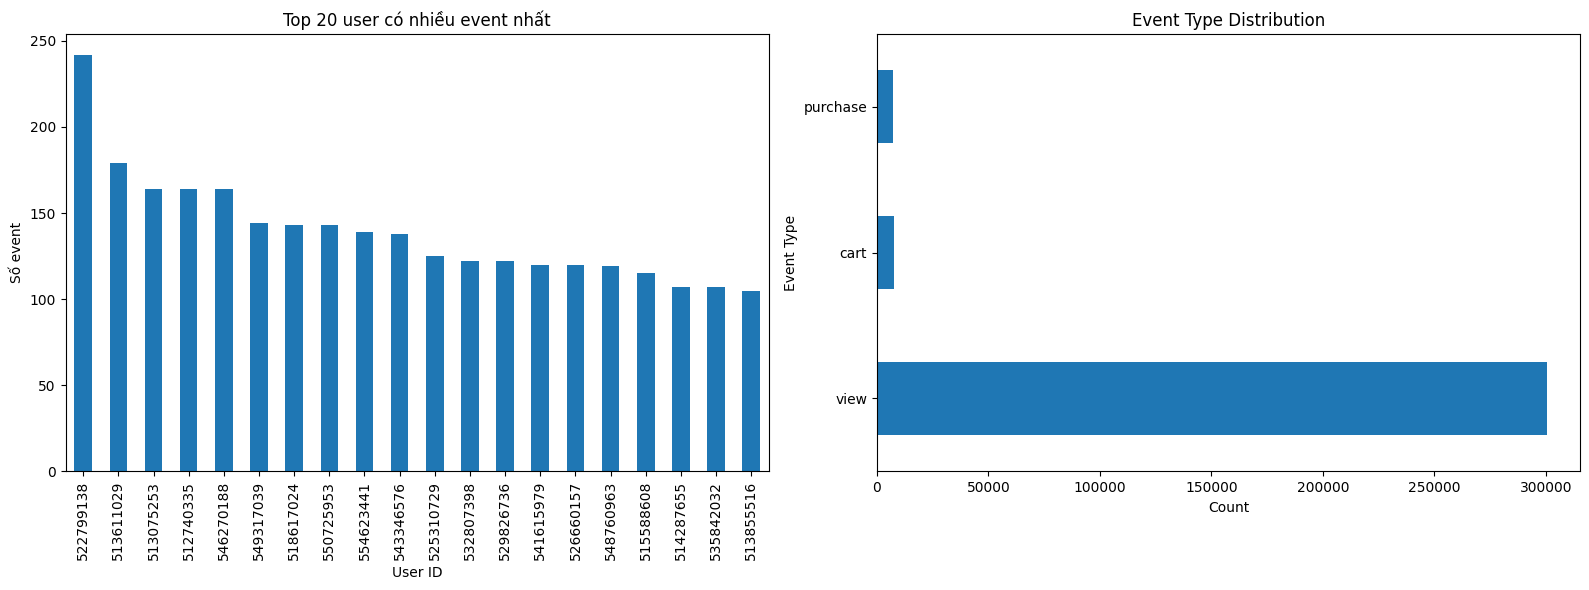

event_type,view,cart,purchase
count,300272.00,7499.00,7400.00
ratio,0.95,0.02,0.02


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

new_data_clean["user_id"].value_counts().head(20).plot(kind="bar", ax=axes[0])
axes[0].set_title("Top 20 user có nhiều event nhất")
axes[0].set_xlabel("User ID")
axes[0].set_ylabel("Số event")

ET = new_data_clean["event_type"].value_counts().to_frame()
ET.columns = ["count"]
ET["ratio"] = (ET["count"] / new_data_clean.shape[0]).round(2)

ET["count"].plot(kind="barh", ax=axes[1])
axes[1].set_title("Event Type Distribution")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Event Type")

plt.tight_layout()
plt.show()

display(ET.T.style.format("{:.2f}").set_caption("Count and Ratio of Event Types"))

#### Tính các tỷ lệ chuyển đổi (conversion rate) giữa các hành vi trong dữ liệu e-commerce.

In [10]:
def compute_conversion_rates(ET):
    required = ["view", "cart", "purchase"]
    for ev in required:
        if ev not in ET.index:
            raise ValueError(f"Event '{ev}' không tồn tại trong dữ liệu ET")

    view_cart_ratio = ET.loc["cart", "count"] / ET.loc["view", "count"] * 100
    cart_purchase_ratio = ET.loc["purchase", "count"] / ET.loc["cart", "count"] * 100
    view_purchase_ratio = ET.loc["purchase", "count"] / ET.loc["view", "count"] * 100

    print("Conversion Rates: ")
    print(f"View → Cart       : {view_cart_ratio:.2f}%")
    print(f"Cart → Purchase   : {cart_purchase_ratio:.2f}%")
    print(f"View → Purchase   : {view_purchase_ratio:.2f}%")

    return view_cart_ratio, cart_purchase_ratio, view_purchase_ratio

view_cart, cart_purchase, view_purchase = compute_conversion_rates(ET)

Conversion Rates: 
View → Cart       : 2.50%
Cart → Purchase   : 98.68%
View → Purchase   : 2.46%


In [11]:
categories = new_data_clean["category_code"].unique()

category_result = []

for cat in categories:
    df_cat = new_data_clean[new_data_clean["category_code"] == cat]
    ET_cat = df_cat["event_type"].value_counts()

    view = ET_cat.get("view", 0)
    cart = ET_cat.get("cart", 0)
    purchase = ET_cat.get("purchase", 0)

    view_cart = (cart / view * 100) if view > 0 else 0
    cart_purchase = (purchase / cart * 100) if cart > 0 else 0
    view_purchase = (purchase / view * 100) if view > 0 else 0

    category_result.append(
        [
            cat,
            view,
            cart,
            purchase,
            round(view_cart, 2),
            round(cart_purchase, 2),
            round(view_purchase, 2),
        ]
    )

category_df = pd.DataFrame(
    category_result,
    columns=[
        "category",
        "view",
        "cart",
        "purchase",
        "view→cart(%)",
        "cart→purchase(%)",
        "view→purchase(%)",
    ],
)

display(category_df)

,category,view,cart,purchase,view→cart(%),cart→purchase(%),view→purchase(%)
0,appliances.environment.water_heater,2008,52,66,2.59,126.92,3.29
1,computers.notebook,14095,26,224,0.18,861.54,1.59
2,electronics.smartphone,127278,5945,4629,4.67,77.86,3.64
3,computers.desktop,4514,2,46,0.04,2300.00,1.02
4,apparel.shoes.keds,4248,0,27,0.00,0.00,0.64
...,...,...,...,...,...,...,...
117,computers.peripherals.camera,66,0,0,0.00,0.00,0.00
118,apparel.shorts,5,0,0,0.00,0.00,0.00
119,apparel.sock,24,0,0,0.00,0.00,0.00
120,apparel.costume,3,0,0,0.00,0.00,0.00


#### Phân phối giá sản phẩm 

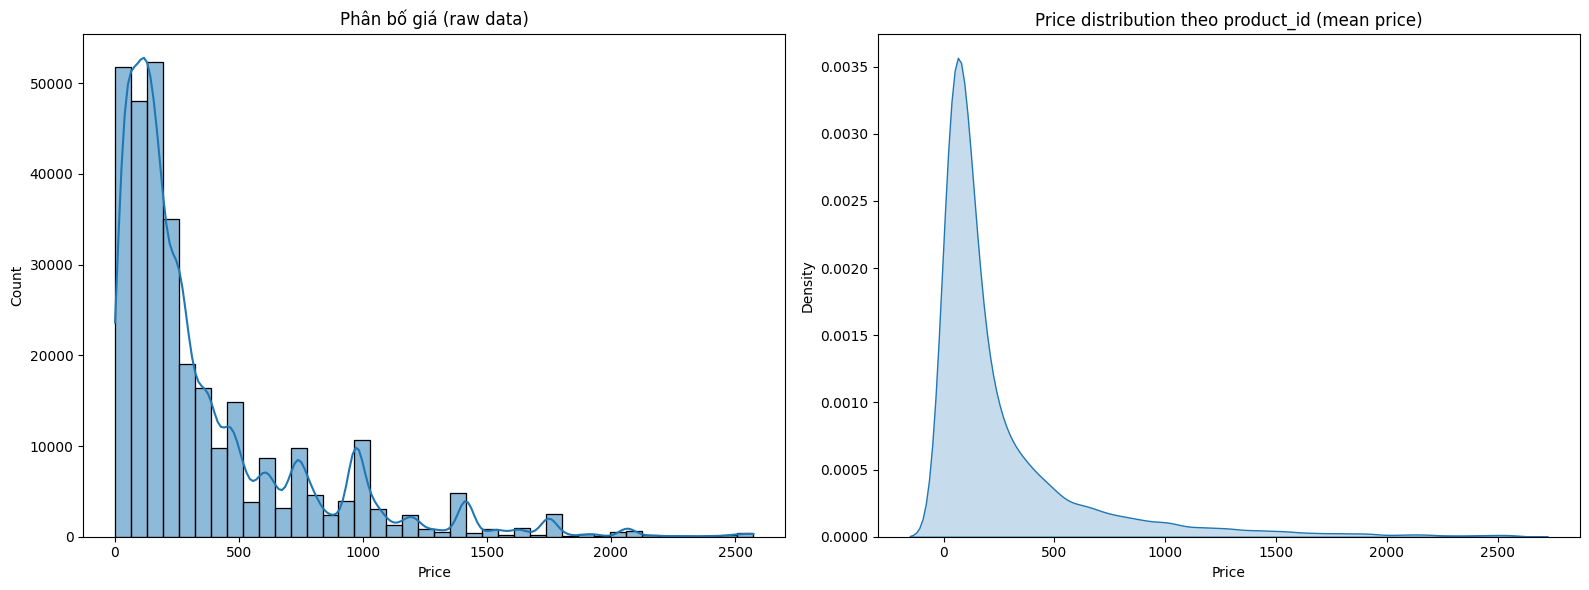

In [12]:
new_data_clean["price"] = pd.to_numeric(new_data_clean["price"], errors="coerce")

products = new_data_clean.groupby("product_id").agg(
    {"category_code": "first", "brand": "first", "price": "mean"}
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(new_data_clean["price"].dropna(), bins=40, kde=True, ax=axes[0])
axes[0].set_title("Phân bố giá (raw data)")
axes[0].set_xlabel("Price")

sns.kdeplot(x=products["price"].dropna(), fill=True, ax=axes[1])
axes[1].set_title("Price distribution theo product_id (mean price)")
axes[1].set_xlabel("Price")

plt.tight_layout()
plt.show()

#### Phân bố giá và số lượng sản phẩm giữa 5 danh mục phổ biến nhất trong tập dataset: 

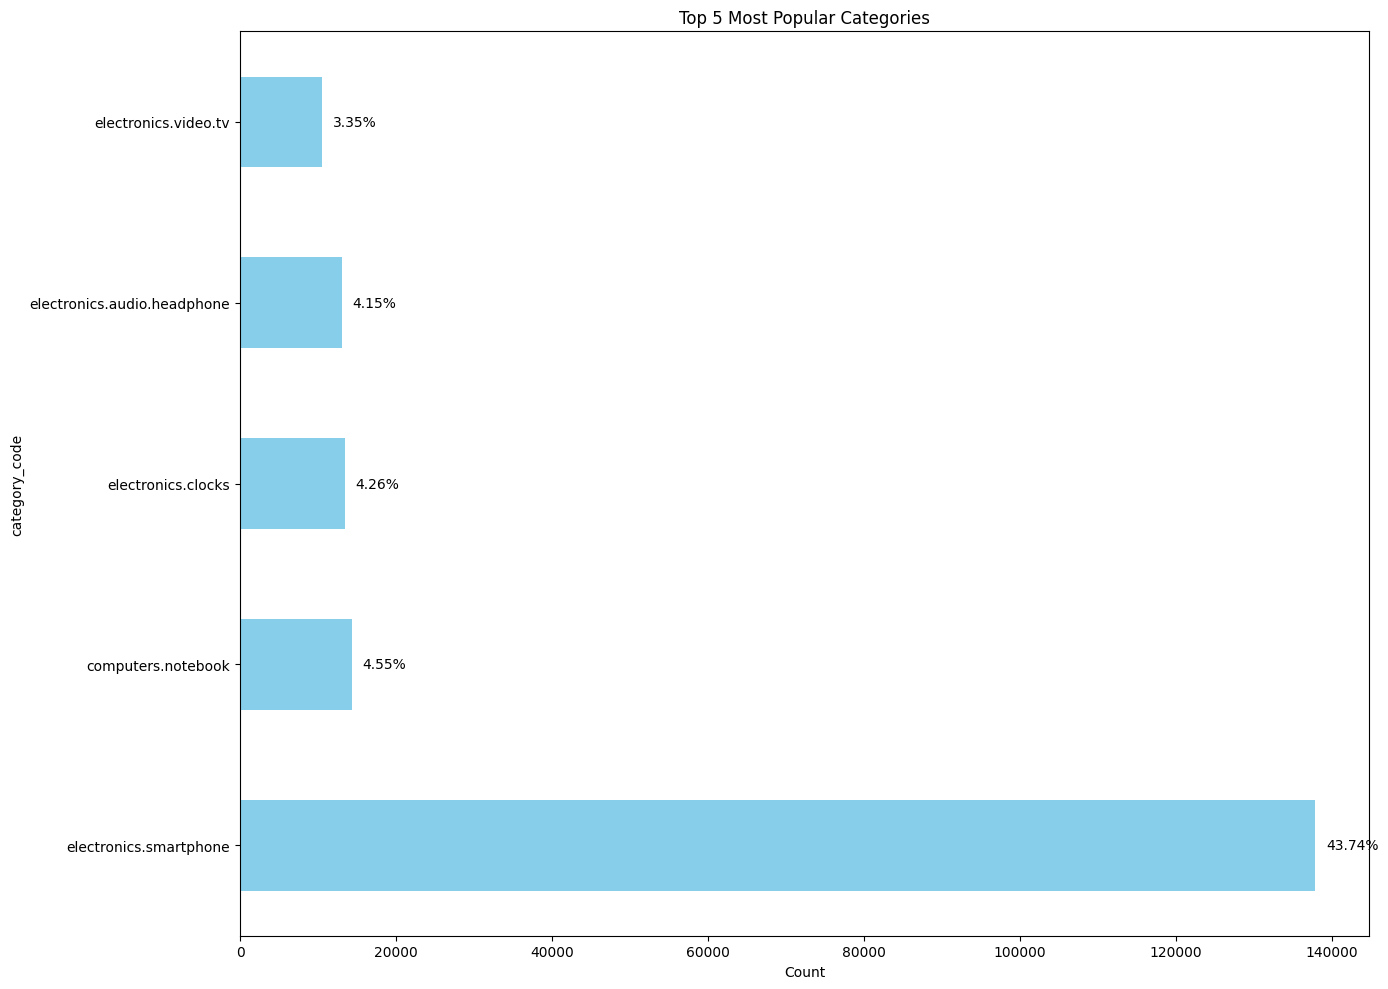

category_code,electronics.smartphone,computers.notebook,electronics.clocks,electronics.audio.headphone,electronics.video.tv
count,137852.00,14345.00,13436.00,13078.00,10547.00
ratio,43.74,4.55,4.26,4.15,3.35


category_code,electronics.clocks,electronics.smartphone,computers.notebook,electronics.audio.headphone,electronics.video.tv
count,1524,916,689,687,334


C:\Users\NGUYEN GIA KHANH\AppData\Local\Temp\ipykernel_16308\850537256.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


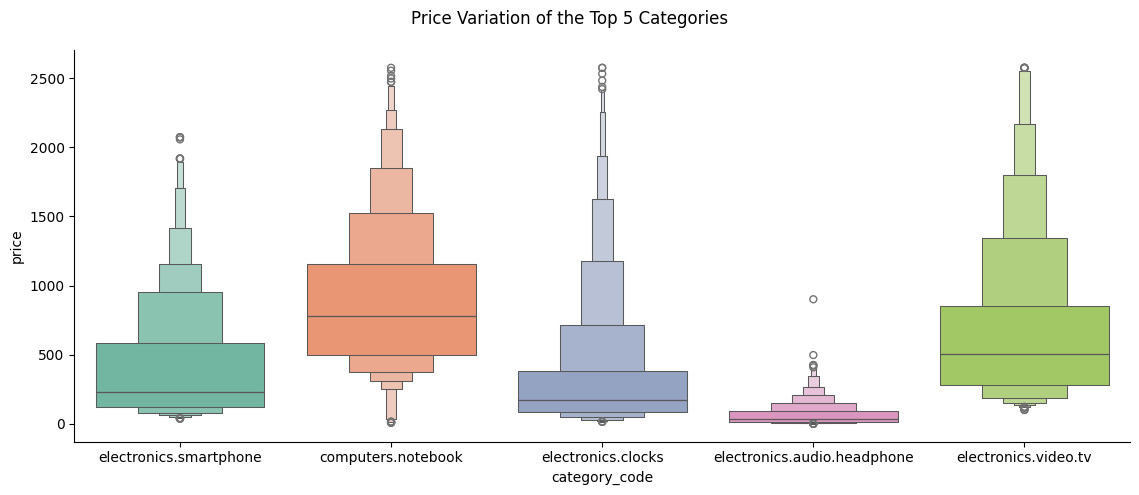

In [13]:
popular_categories = new_data_clean["category_code"].value_counts().to_frame()
popular_categories.columns = ["count"]
popular_categories["ratio"] = np.round(
    popular_categories["count"] / new_data_clean.shape[0] * 100, 2
)

top5_df = popular_categories.head(5)

plt.figure(figsize=(14, 10))
ax = top5_df["count"].plot(kind="barh", color="skyblue")
plt.title("Top 5 Most Popular Categories")
plt.xlabel("Count")


for i, (count, ratio) in enumerate(zip(top5_df["count"], top5_df["ratio"])):
    ax.text(
        count + max(top5_df["count"]) * 0.01,
        i,  
        f"{ratio}%",  
        va="center",
    )

plt.tight_layout()
plt.show()

display(
    top5_df.T.style.format("{:.2f}").set_caption("Top 5 Most popular categories (%)")
)

top_categories = top5_df.index.tolist()
top5 = products[products["category_code"].isin(top_categories)]

display(
    top5["category_code"]
    .value_counts()
    .to_frame()
    .T.style.set_caption("Number of items per top 5 category")
)

palette = sns.color_palette("Set2", n_colors=5)
g = sns.catplot(
    data=top5,
    x="category_code",
    y="price",
    kind="boxen",
    aspect=2.3,
    order=top_categories,
    palette=palette,
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Price Variation of the Top 5 Categories")
plt.show()

#### Phân tích tổng quan số lượng và phân bố giá của các thương hiệu:

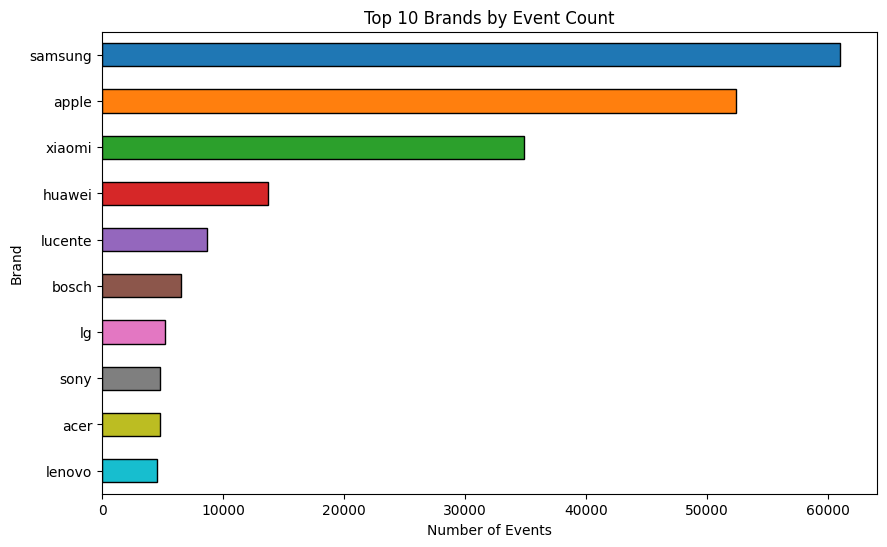

brand,samsung,apple,xiaomi,huawei,lucente,bosch,lg,sony,acer,lenovo
count,60975.00,52349.00,34834.00,13731.00,8633.00,6533.00,5199.00,4829.00,4814.00,4575.00
ratio,0.12,0.10,0.07,0.03,0.02,0.01,0.01,0.01,0.01,0.01


C:\Users\NGUYEN GIA KHANH\AppData\Local\Temp\ipykernel_16308\3322905662.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


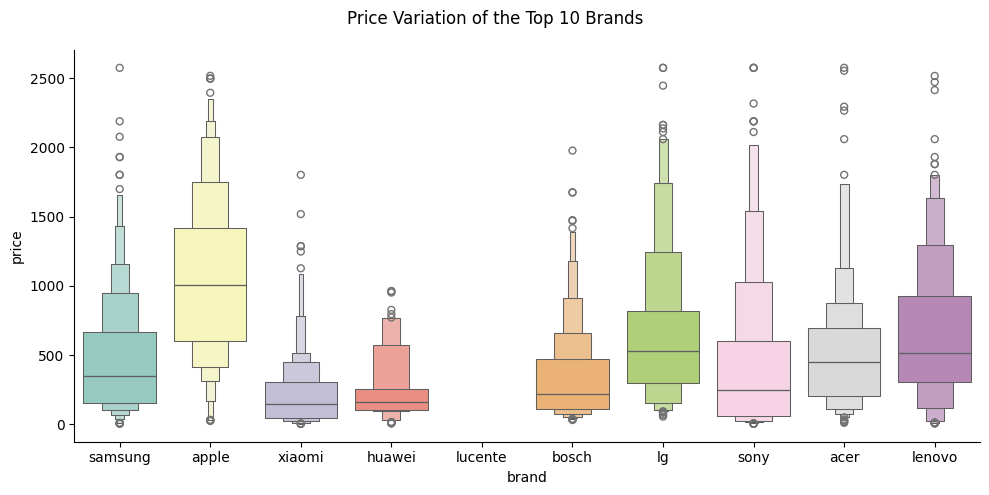

In [14]:
B = new_data["brand"].value_counts().to_frame()
B.columns = ["count"]
B["ratio"] = np.round(B["count"] / new_data.shape[0], 2)

top_brands = B.head(10).index.tolist()
top10_df = products[products["brand"].isin(top_brands)]

f, ax = plt.subplots(1, figsize=(10, 6))
colors = sns.color_palette("tab10", 10)  # 10 màu
B.loc[top_brands, "count"].plot(kind="barh", ax=ax, color=colors, edgecolor="black")
ax.set_title("Top 10 Brands by Event Count")
ax.set_xlabel("Number of Events")
ax.set_ylabel("Brand")
plt.gca().invert_yaxis()  
plt.show()

display(
    B.loc[top_brands].T.style.format("{:.2f}").set_caption("Top 10 Brands by Ratio")
)

g = sns.catplot(
    data=top10_df,
    x="brand",
    y="price",
    kind="boxen",
    aspect=2.0,
    order=top_brands,
    palette="Set3",
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Price Variation of the Top 10 Brands")
plt.show()